1 window = 1 prediction <br>
1 timestep = 1ne Nummer, bei einer windowSize von 7 gibt es 7 timesteps, nach diesen 7 timesteps kommt eine prediction <br>
1 timestep = eine Veränderung des Cell_state <br>
Anzahl timesteps entspricht windowsSize <br>
1 batch = 1 Anpassung aller Gewichte (lstm celle und output layer), da nicht als nicht-trainierbar erzeugt(die variablen)

normalisieren = original-werte skalieren zum Beispeil von [+inf,-inf] to [0,1] <br><br>
logits = nicht normalisierte Prediction(also nicht zwischen irgendwelchen festen Werten wie 0 und 1), also Prediction die outputLayer zum Beispiel auswirft; Logits werden im Folgeschritt als Input der Softmax o.ä. genommen (name logits impliziert, dass werte anschließend in aktivierungsfunktion kommen) <br>
-> bei uns meist trotzdem im Bereich [-1,1] da Input per MinMaxScaler skaliert wurde, bei uns wird im Anschluss aber auch keine Aktivierungsfunktion durchlaufen<br><br>
lsltm-stateisTupel=Yes: LSTM hat cell state and output, cell state behält lstm cell für sich, output wird geoutputtet -> beides aber brauch lstm cell für nächsten time step, deshalb Tupel, eben von (cellstate,output) <br>


In [1365]:
import numpy as np
import tensorflow as tf
import pandas as pd
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from numpy import array
import datetime

## Step 0. Loading dataset

In [1366]:
tesla_stocks = pd.read_csv('AdidasAG10Years.csv')


In [1367]:
tesla_stocks.head()

,date,close,volume,open,high,low
0,16:00,104.760,"57,787",NaN,105.5700,104.5200
1,2017/12/01,104.595,79476.0000,104.25,104.9999,104.0000
2,2017/11/30,104.440,54341.0000,105.35,105.4840,104.2500
3,2017/11/29,104.920,106076.0000,107.21,107.3500,104.9200
4,2017/11/28,106.285,62220.0000,106.65,106.6500,105.9754


In [1368]:
data_to_use = tesla_stocks['close'].values
data_to_use = np.flipud(data_to_use) # flips values to get the newest values to the end

In [1369]:
print('Total number of days in the dataset: {}'.format(len(data_to_use)))

Total number of days in the dataset: 2522


## Step 1. Data preprocessing <br>
#### Input :     INPUT -> lstm -> outputlayer -> mse(bptt)

#### Step 1.1 Scaling data mit Standart-Scaler

In [1370]:
scaler = MinMaxScaler(feature_range=(-1,1)) # mapped alle Werte auf [-1;1] aufgrund von eventuell sehr hohen Werten -> squard error


#### Data vor der Skalierung

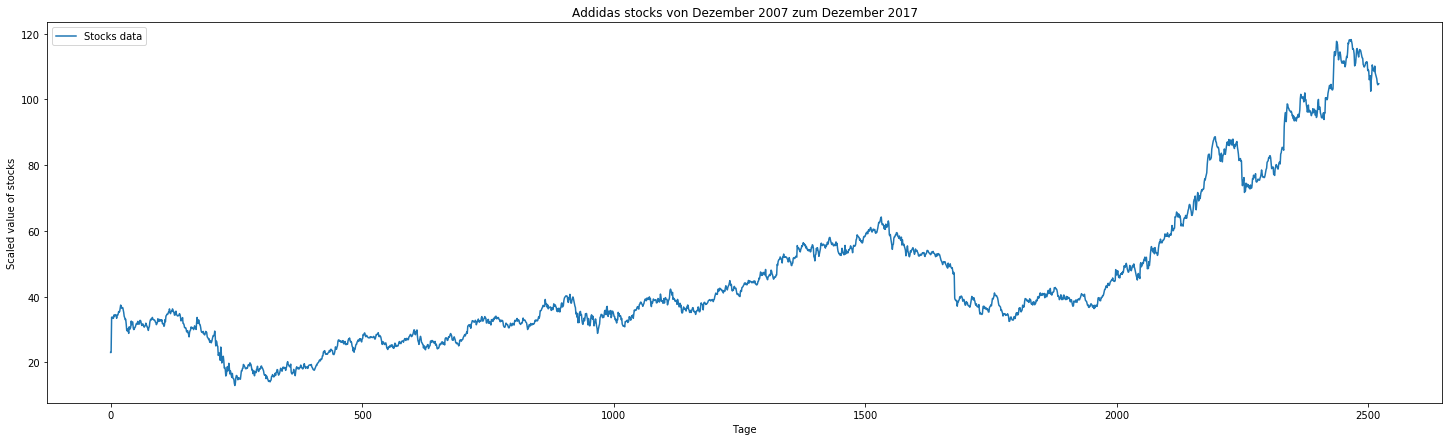

In [1371]:
plt.figure(figsize=(25,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Addidas stocks von Dezember 2007 zum Dezember 2017')
plt.xlabel('Tage')
plt.ylabel('Scaled value of stocks')
plt.plot(data_to_use, label='Stocks data')
plt.legend()
plt.show()

In [1372]:
reshaped_dataset = data_to_use.reshape(-1,1) #why? cause 1 feature
   #reshape(3,4,2)
   #reshape = Form des Array umformen ohne Daten zu ändern, lesen wie umformen into reshape([3],[4],[2])
   #-1 = anpassung dieser Dimension an die anderen, die man reshape gibt
   #reshape(-1,1) bedeuted also das man irgendwie [unbekannt][1] haben will, wobei sich unbekannt eben aus
   #[1] und der Gesamtzahl ableiten lässt
scaler = scaler.fit(reshaped_dataset)
scaled_dataset = scaler.transform(reshaped_dataset)

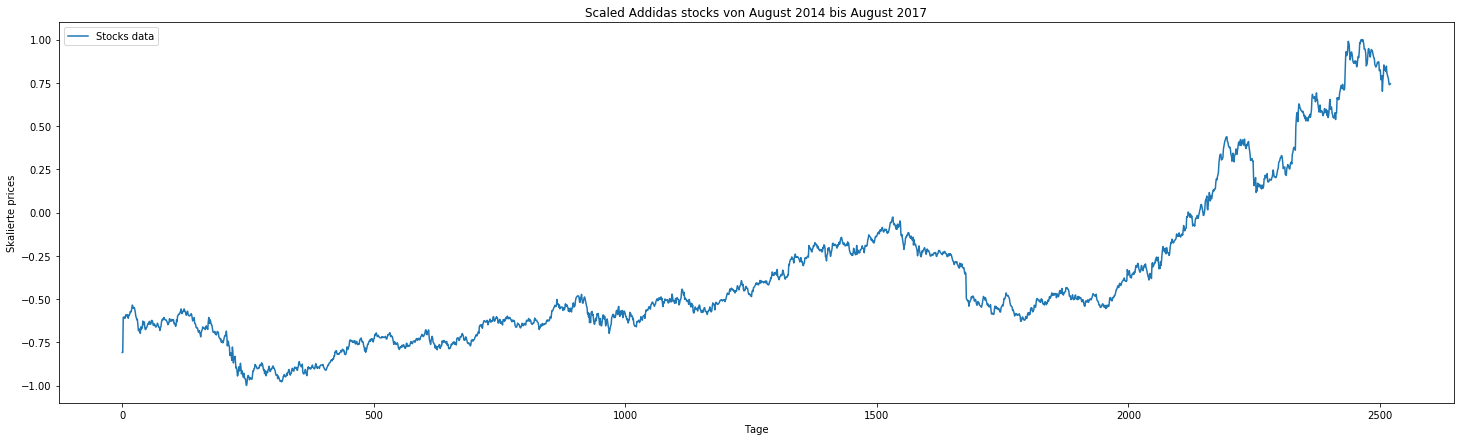

In [1373]:
plt.figure(figsize=(25,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled Addidas stocks von August 2014 bis August 2017')
plt.xlabel('Tage')
plt.ylabel('Skalierte prices')
plt.plot(scaled_dataset, label='Stocks data')
plt.legend()
plt.show()

In [1374]:
window_size_all = 7
batch_size = 8
epochs = 1 #eig 3
train_range = 144
dropout=0,2
number_of_layers= 2

###### windows data <br>
values 1-7 in einem window <br >
der 7. value wird zusätzlich in eben y gespeichert (=Label)

In [1375]:
def window_data(data, window_size): #Taktik: speichere eine Liste von Werten der Datensätze von x bis x+ windowssize, danach speichere eine Liste von Werten der Datensätze von x+1 bis x+1+windowssize, damit man
                                    #praktisch immer nach 1 Windows eine Prediction machen kann
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1: #heißt eigentlich nach windowsSize Tagen = eine Prediction
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

#### Step 1.2 Windowing the dataset

In [1376]:
X, y = window_data(scaled_dataset, window_size_all) #mn
#X, y = window_data(reshaped_dataset, window_size_all)

#### Step 1.3 Creating Training and Testing sets
trainingsdaten: 0-700 <br>
testDaten 700-X

In [1377]:
X_train  = np.array(X[:train_range])
y_train = np.array(y[:train_range])

X_test = np.array(X[train_range:])
y_test = np.array(y[train_range:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (144, 7, 1)
y_train size: (144, 1)
X_test size: (2371, 7, 1)
y_test size: (2371, 1)


## Step 2. RNN - LSTM - Netzwerk definieren -> (Funktionen und Objekte definieren)

#### Hidden Layer :     input -> LSTM -> outputlayer -> mse(bptt) <br>
 Erstellung einer Zelle (komplettes Hiddenlayer)

In [1378]:
def LSTM_cell(hidden_layer_size, batch_size,number_of_layers,dropout_rate, dropout=True):
    
    #layer = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size)
    
    
   
    #layer_list = [layer]*number_of_layers
    layer_list = []
    for counter in range(number_of_layers):
        layer = tf.nn.rnn_cell.BasicLSTMCell(hidden_layer_size)
        if dropout:
            layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        layer_list.append(layer)
        

        
    cell = tf.contrib.rnn.MultiRNNCell(layer_list) # multi-RNN stacked Basic Cell übereinander: basiccell1 -> basiccell2 -> bc3 -> ... -> output
    #warum diese Syntax -> [layer] * number_of_layers ? Weil eine Liste von BasicLSTMCell -en gebraucht wird und durch Python-Syntax wird dadurch number_of_hiddenlayers oft ein layer hier aka BasicLSTMCell erstellt
    
    init_state = cell.zero_state(batch_size, tf.float32) #zero_state -> alle values to 0
    print(type(init_state),"n",init_state)
    return cell, init_state

#### Output Layer :     Input -> LSTM -> OUTPUTLAYER -> mse(bptt)

In [1379]:
def output_layer(lstm_output, in_size, out_size):
    
    x = lstm_output[:, -1, :] #es interessiert nur der letzte output... -1 d.h. in python letztes element, [batch_size][timesteps][features] -> [batch_size][hiddenlayer_size]
    weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.05), name='output_layer_weights')
    bias = tf.Variable(tf.zeros([out_size]), name='output_layer_bias')
    output = tf.matmul(x, weights) + bias #result: 7x1 ! # warum matmul und nicht skalar-wise                                                                                                     -> scalar -wise nur bei normalen rnn, da man selbe matrizen mit einander multipliziert oder eben bei multidim. NN wenn jedes Layer die selbe Form hat dann auch irgendwie glaube
                                          #hier: 7x1 * 1x1   
                                            #warum keine Aktivierungsfunktion ? -> wir rechnen keine Wahrscheinlichkeiten aus sondern direkt die Preis-Werte
    
    return output #7x1

###### gradient clipping  <br>
gradienten clipping = man beschränkt den exploding gradient auf eine max Zahl, sodass er nicht über diese max Zahl (Limit) gehen kann <br>
clipping hilft gegen exploding gradient, siehe standford folie 11: 46, code ist fast der selbe  <br>
eigentlich nur bei rekurrenten neuronalen Netzen -> <b> lstm gegen vanishing and clipping gegen exploding <b>

In [1380]:
def opt_loss(logits, targets, learning_rate, grad_clip_margin):
    
    losses = []
    for i in range(targets.get_shape()[0]):
        losses.append([(tf.pow(logits[i] - targets[i], 2))]) #mse
        
        
        ####
        #hier müsste eigentlich accuracy berechnet werden, eben wie auch loss -> gucken nach tensorflow define loss and accuracy
        #nein doch nicht, da accuarcy ja nicht nur bezüglich unserer richtigen Predictions berechnet wird, hier wird ja 
        ###
        
        
        
    loss = tf.reduce_sum(losses)/(2*batch_size)
    #Cliping the gradient loss
    
    gradients = tf.gradients(loss, tf.trainable_variables())
    clipper_, _ = tf.clip_by_global_norm(gradients, grad_clip_margin)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables())) #zip: a = [a1,a2]; b=[b1,b2] zip(a,b) = [(a1,b1),(a2,b2)]
    return loss, train_optimizer

#### RNN - Object: <br/> <br/> 
Hiddenlayer=1, hidden_layer_size=512, learning_rate=0.001, dropout=80%, window size=7, batch_size=7, 

In [1381]:
class StockPredictionRNN(object):
    
    def __init__(self, dropout_rate,learning_rate=0.001, batch_size=7, hidden_layer_size=512, number_of_layers=2, 
                 dropout=True, number_of_classes=1, gradient_clip_margin=4, window_size=7):
    
        self.inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1], name='input_data')
        
        self.targets = tf.placeholder(tf.float32, [batch_size, 1], name='targets')

        cell, init_state = LSTM_cell(hidden_layer_size, batch_size, number_of_layers, dropout, dropout_rate)
        
        outputs, states = tf.nn.dynamic_rnn(cell, self.inputs, initial_state=init_state)
        #outputs = tf.Print(outputs,[outputs, tf.shape(outputs)], message="value of output:" )
    

        self.logits = output_layer(outputs, hidden_layer_size, number_of_classes) # logits = die wirklichen Predictions des netzwerkes im Format [batchNummer][AnzahlPredictions] wobei hier: [7][1]  

        self.loss, self.opt = opt_loss(self.logits, self.targets, learning_rate, gradient_clip_margin)

## Step 3. RNN - LSTM - Netzwerk erstellen -> (Model als Objekt erstellen)

In [1382]:
tf.reset_default_graph()
model = StockPredictionRNN(batch_size=batch_size, dropout_rate=dropout, window_size=window_size_all,number_of_layers = number_of_layers)

<class 'tuple'> n (LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros:0' shape=(8, 512) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros_1:0' shape=(8, 512) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState_1/BasicLSTMCellZeroState/zeros:0' shape=(8, 512) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState_1/BasicLSTMCellZeroState/zeros_1:0' shape=(8, 512) dtype=float32>))


## Step 4. Netzwerk trainieren

In [1383]:
session =  tf.Session()

In [1384]:
session.run(tf.global_variables_initializer())

In [1385]:
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train): #ein Durchlauf = 1 batch = 1 BPTT = 1 Anpassung der Gewichte = 1x "Lernen"
                                            #Anzahl Durchläufe = Anzahl der Batch-es insgesamt = nicht direkt spezifiziert, indirekt festgelegt durch , wann reichen die vorhandenen Daten nicht mehr(siehe Schleifenbedingung)
        X_batch = X_train[ii:ii+batch_size]
        
        y_batch = y_train[ii:ii+batch_size]
        o, c, _ = session.run([model.logits, model.loss, model.opt], feed_dict={model.inputs:X_batch, model.targets:y_batch})
        
        #o=model.logits=logits 7x1 bzw [batchSize][Prediction] -> windowsSize wurde herausgestrichen, da pro windows Size ehh immer 1 prediction war -> windowSize kann raus
        #c=model.loss=loss
        #_=model.opt=für Weiteres unbenutzt = train_optimizer
        
        #correct_prediction=tf.equal(tf.argmax(,1),tf.argmax(y,1))
        #accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
        #acc=sess.run(accuracy,feed_dict={x:X_batch,y:y_batch})
        
       
        accuracy =tf.metrics.accuracy(y_batch,o)
        
        
        
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 1) == 0:
        print('Epoch {}/{}'.format((i+1), epochs), ' Current loss: {}'.format(np.mean(epoch_loss))) #i+1 da range(epochs) von 0 beginnt, ohne +1 -> 0/1 beim ersten Durchlauf

Epoch 1/1  Current loss: 0.024709364399313927


In [1386]:
sup =[] #wird die Werte der Predictions speichern, Zweck: von 7x1(traind_scores) to [7]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j])

## Step 5. Testing the network <br>

In [1387]:
tests = []
i = 0
while i+batch_size <= len(X_test):
    
    o = session.run([model.logits], feed_dict={model.inputs:X_test[i:i+batch_size]})
    
    i += batch_size
    tests.append(o)

In [1388]:
#just extracting [[[VALUES]]] and transform it to a flat list [VALUES]
test_results = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        test_results.append(tests[i][0][j])

## Step 6. Plotting predictions from the network

#### zuerst skalierte Variante plotten:

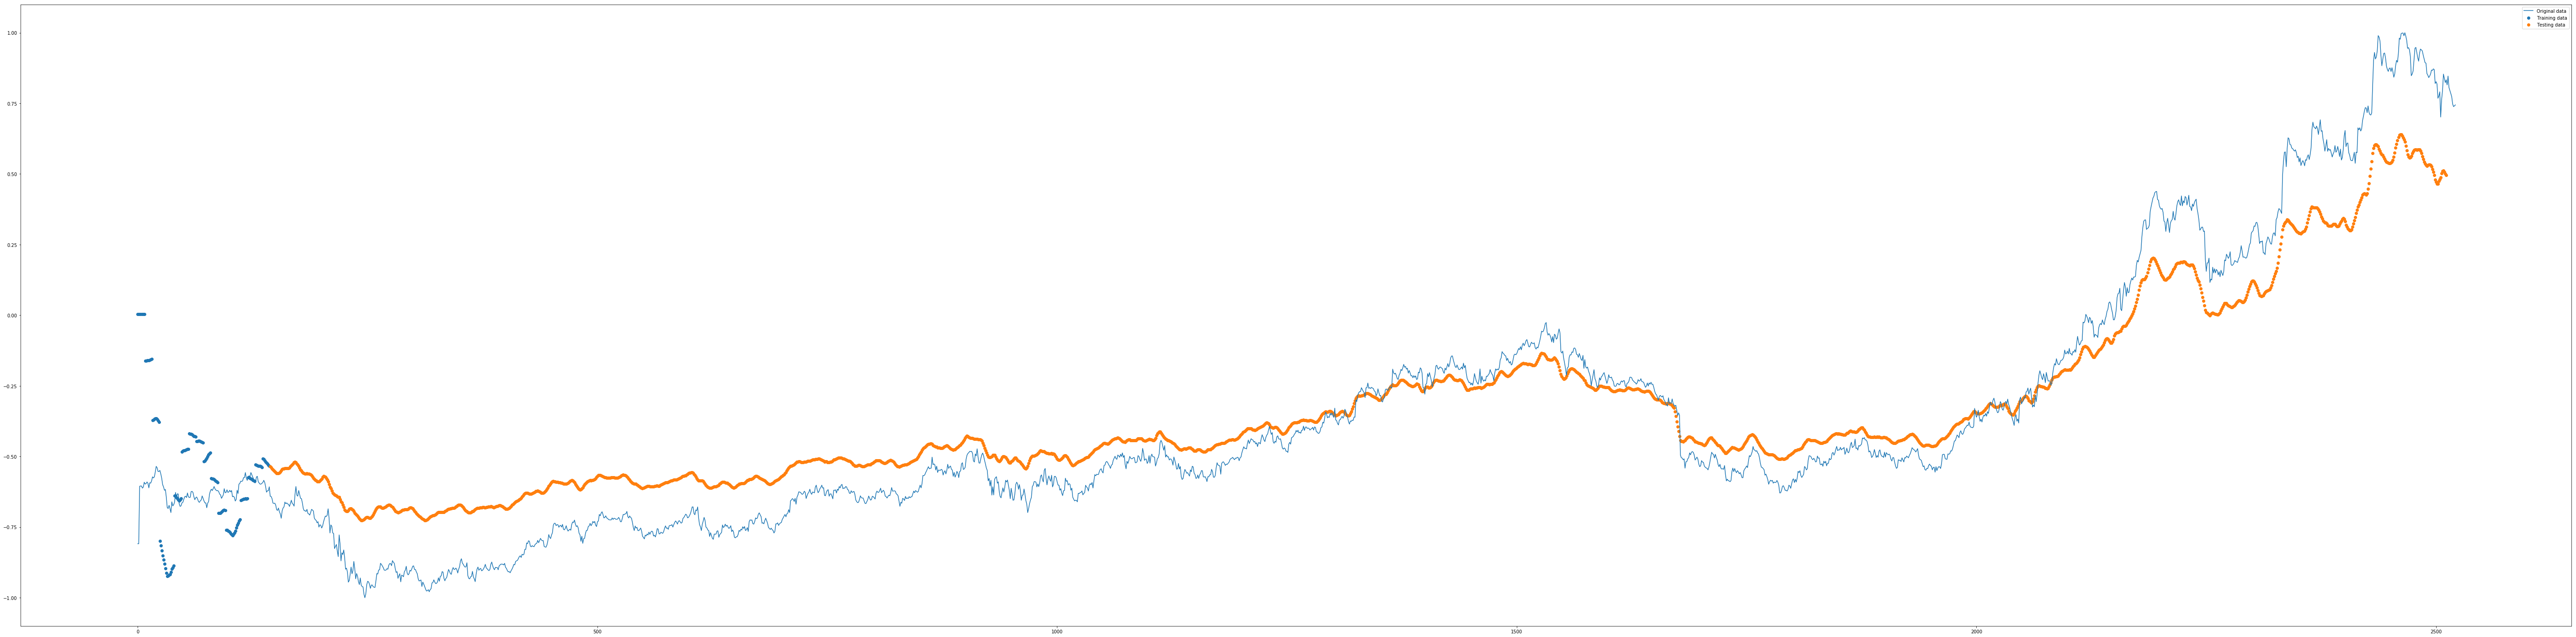

In [1389]:

plt.figure(figsize=(100, 25))
plt.plot(scaled_dataset, label='Original data')
plt.scatter(range(train_range),sup, label='Training data')
plt.scatter(range(train_range,len(test_results)+train_range), test_results, label='Testing data') #[train_range:len(tests_new)+train_range]
plt.legend()
plt.savefig('plots/plot-scaled ' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S").replace(":", "_")+ '.png')
plt.show()


#### danach unskalierte Variante:

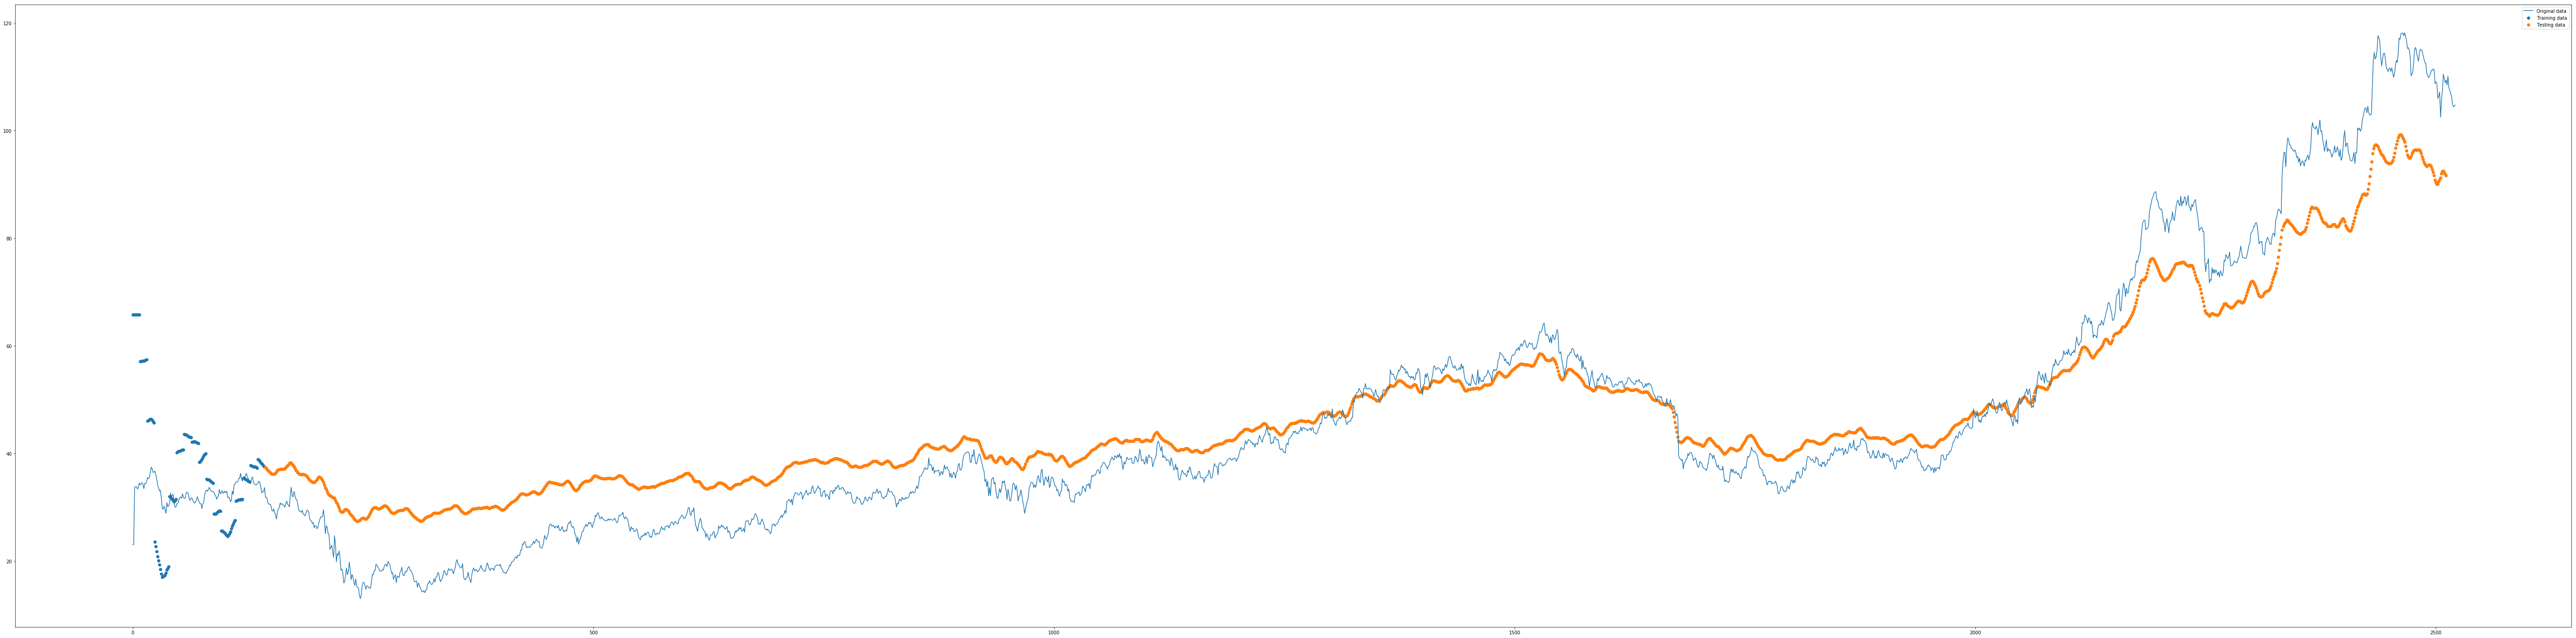

In [1390]:
#sup #= scaler.inverse_transform(sup)
sup = scaler.inverse_transform(sup)
test_results_scaled = scaler.inverse_transform(test_results) #scaler.inverse_transform(test_results)
#test_results_scaled = scaler.transform(test_results_scaled)
test_results_reshaped = test_results_scaled.reshape(-1)

#test_results = [scaler.inverse_transform(x) for x in test_results]
                                         


plt.figure(figsize=(100, 25))
plt.plot(data_to_use, label='Original data')
plt.scatter(range(train_range),sup, label='Training data')
plt.scatter(range(train_range,len(test_results_reshaped)+train_range), test_results_reshaped, label='Testing data') #, 
plt.legend()
plt.savefig('plots/plot-unscaled ' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S").replace(":", "_") + '.png')
plt.show()

In [1391]:
#var_23 = [v for v in tf.global_variables() if v.name == "accuracy"]
#value = session.run(var_23)
#print(value)


In [1392]:
var_names = [v.name for v in tf.trainable_variables()]
values = session.run(var_names)
for k, v in zip(var_names, values):
    print(k, v)

session.close()

rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0 [[ 0.02883017 -0.02670293  0.03618967 ...,  0.00580378 -0.04823567
   0.02045877]
 [ 0.00093787 -0.01540928  0.04588931 ..., -0.00632835 -0.01931774
   0.04602993]
 [ 0.00439301  0.04629309  0.03369054 ...,  0.02403793  0.0269029
  -0.00500051]
 ..., 
 [ 0.00330316  0.01674631  0.02964678 ..., -0.04633938  0.03964457
  -0.02530027]
 [ 0.01280131  0.04083371 -0.02418452 ..., -0.00583987 -0.00353344
   0.01271891]
 [ 0.00279609 -0.02520734  0.00636254 ..., -0.00505624  0.01423053
   0.02153559]]
rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0 [-0.00903468  0.00107922 -0.00310462 ...,  0.00133299  0.00095424
 -0.00769163]
rnn/multi_rnn_cell/cell_1/basic_lstm_cell/kernel:0 [[-0.02571103  0.01088233  0.04398992 ...,  0.02017012  0.02450315
   0.03474677]
 [ 0.04487251 -0.01911137  0.00367005 ..., -0.00570871  0.04016571
   0.04303616]
 [-0.04234485  0.02374431  0.01223486 ...,  0.02226044 -0.01411987
  -0.02546546]
 ..., 
 [-0.01094336 -0.

In [1393]:
string = "hi"
result = [string]*3
print(id(result[0]))
print(id(result[1]))
string1 = "cool"
print(id(string1))

1755785100736
1755785100736
1755905338368


## Accuracy

In [1394]:
# Accuracy
   # correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    #accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')